<a href="https://colab.research.google.com/github/ruby199/pytorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment


What is Model Deployment?

ML model deployment is the act of making your machine learning model(s) available to someone or something else.

##0. Get setup


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


## 1. Getting Data

The dataset we're going to use for deployting a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3884, done.
remote: Counting objects: 100% (1075/1075), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 3884 (delta 977), reused 980 (delta 933), pack-reused 2809
Receiving objects: 100% (3884/3884), 648.04 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (2268/2268), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline


So our goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).


To try and achieve these results, let's bring in our best performing models from the previous sections:

1. **EffNetB2 feature extractor** (EffNetB2 for short) - originally created in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models) using [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) with adjusted `classifier` layers.
2. **ViT-B/16 feature extractor** (ViT for short) - originally created in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset) using [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#vit-b-16) with adjusted `head` layers.
    * **Note** ViT-B/16 stands for "Vision Transformer Base, patch size 16".


## 3. Creating an EffNetB2 feature extracture


Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers ( or head layers) for certain problem.

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 151MB/s]


Now to change the classifier head, let's first inspect it using the `classifier` attribute of our model.

In [7]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [9]:
# Set seeds for reproducibility
set_seeds()

# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

In [10]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

### 3.1 Creating a function to make an EffNetB2 feature extractor


In [11]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [12]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2


In [13]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### 3.3 Training EffNetB2 feature extractor


In [14]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves


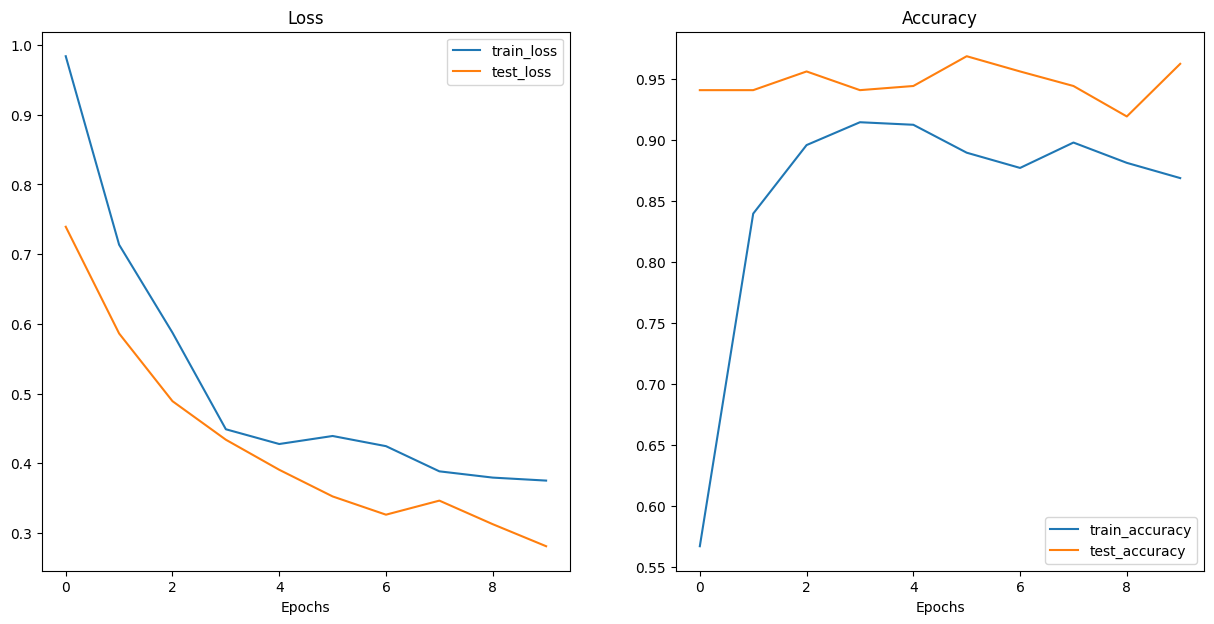

In [15]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor


In [16]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.


In [17]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats


In [18]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [19]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2810868680477142,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Creating a ViT feature extractor

We're up to the second modelling experiment, repeatiung the steps for EffNetB2 but this time with a ViT feature extracor.

In [20]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [21]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Frssze all layers in model
    for param in model.parameters():
      param.requires_grad = False

    # Change classifier head to suit our needs (this will be trinable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflext target number of classes

    return model, transforms

In [23]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.1MB/s]


In [24]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create Dataloader for ViT feature extractor

In [25]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### 4.2 Training ViT feature extractor

We're up to model experiment number two: a ViT feature extractor.


In [26]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves


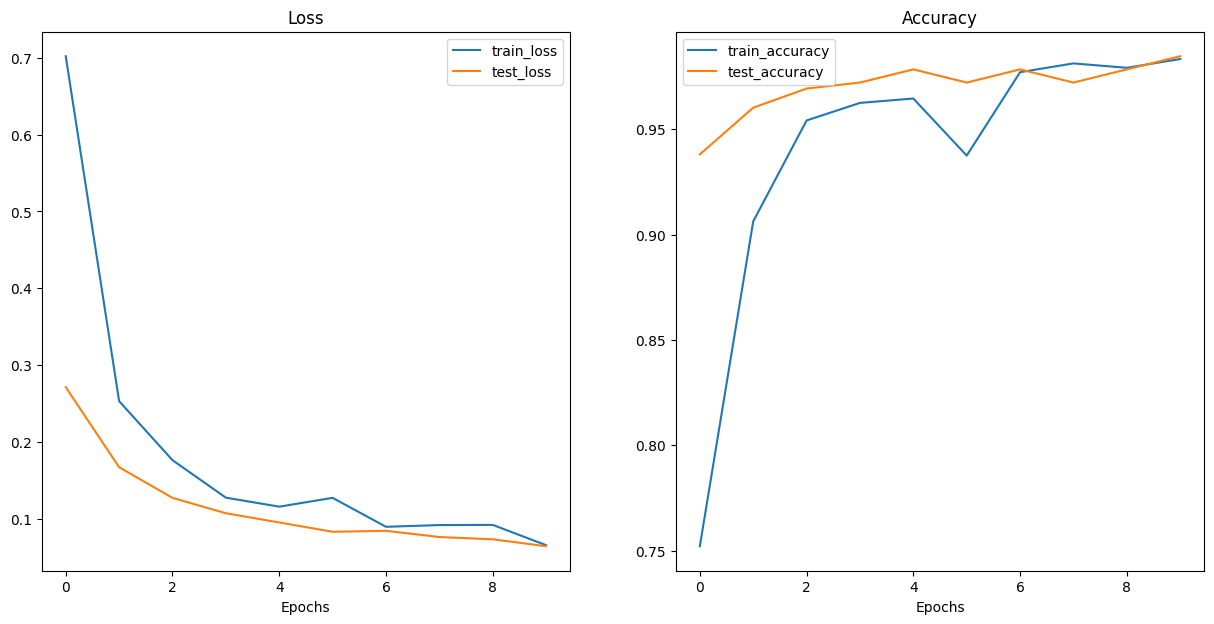

In [27]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor


In [28]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor


In [29]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stats


In [30]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [31]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443454632535577,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

Our goal:
1. performs well (95%+ test accuracy)
2. Fast (30_ FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.
First we'll need a list of test image paths.


In [32]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1972463.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

Steps to create ``pred_and_store()`:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
6. Start the prediction timer using Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer).
7. Open the image using [`PIL.Image.open(path)`](https://pillow.readthedocs.io/en/stable/reference/Image.html#functions).
8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.



In [33]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of havingt a GPU when you deploy you model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`)

In [34]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [35]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8017,
  'pred_class': 'steak',
  'time_for_pred': 0.3354,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7753,
  'pred_class': 'steak',
  'time_for_pred': 0.1242,
  'correct': True}]

In [36]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8017,steak,0.3354,True
1,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.7753,steak,0.1242,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9252,steak,0.1652,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9460,steak,0.2365,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7198,steak,0.2120,True


In [37]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [38]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1459


In [39]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2810868680477142,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1459}

> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using... So generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.




### 5.3 Making and timing predictions with ViT

In [40]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9604,
  'pred_class': 'steak',
  'time_for_pred': 0.8177,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9387,
  'pred_class': 'steak',
  'time_for_pred': 0.6325,
  'correct': True}]

In [42]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9604,steak,0.8177,True
1,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9387,steak,0.6325,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9934,steak,0.6252,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9966,steak,0.6278,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9986,steak,0.6053,True


In [43]:
# See how many correct
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [44]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.8005 seconds


In [45]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443454632535577,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.8005}

## 6. Comparing model results, prediction times and size


In [46]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29,0.1459,EffNetB2
1,0.064435,98.47,85800963,327,0.8005,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - if a model has more parameters, it generally takes longer to compute.
> * * sometimes models with higher parameters can still perform fast
* `model_size` (MB) - EffNetB2 (for our use casee of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) -EffNetB2

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetb2 model and see how it goes.



In [47]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.229234,1.023065,11.135432,11.275862,5.486635


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB`)).


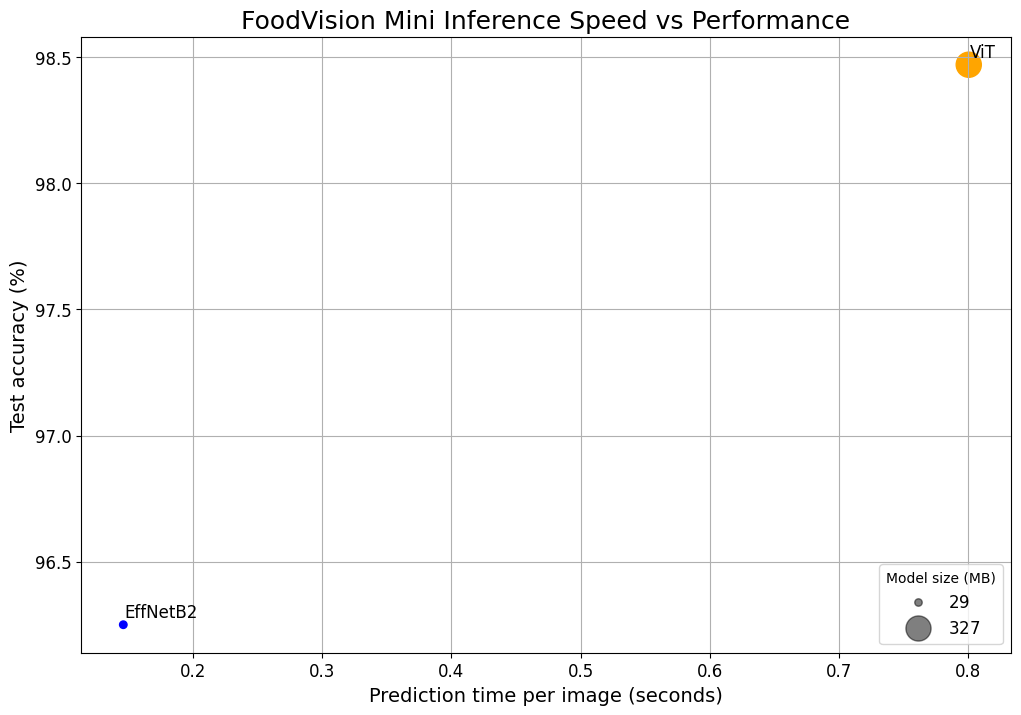

In [48]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
# plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Brining FoodVision Mini to life by creating a Gradio demo

We've decided we'd like to deploy the EffNetB2 model (to begin with, this could always be changed later).

So how can we do that?

There are several ways to deploy a machine learning model each with specific use cases (as discussed above).

We're going to be focused on perhaps the quickest and certainly one of the most fun ways to get a model deployed to the internet.

And that's by using [Gradio](https://gradio.app/).

What's Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

Why create a demo of your models?

Because metrics on the test set look nice but you never really know how you're model performs until you use it in the wild.

In [49]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.8 MB/s eta 0:

### 7.1 Gradio overview

Gradio helps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.
The overall premise of Gradio is to map inputs -> function/model -> outputs.

In our case, for FoodVision Mini, our inputs are images of food, our ML model is EffNetB2 and our outputs are classes of food (pizza, steak or sushi).

```
images of food -> EffNetB2 -> outputs
```

### 7.2 Creating a function to map out inputs and outputs

In [50]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
image of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)
```

In [51]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start a timer
    start_time = timer()

    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqeeze = add batch dimention on 0th index

    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
      # Pass transformed image through the model and turn the prediction logits into probabilities
      pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [52]:
class_names

['pizza', 'steak', 'sushi']

In [53]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/730464.jpg

Prediction label and probability dictionary: 
{'pizza': 0.045247189700603485, 'steak': 0.8950357437133789, 'sushi': 0.05971696600317955}
Prediction time: 0.12789 seconds


### 7.3 Creating a list of example images

The examples for Gradio can be created with the `examples` parameter, see here: https://gradio.app/docs/#building-demos

In [54]:
# Create list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/380739.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1972463.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg']]

### 7.4 Building a Gradio interface


Let's create a Gradio interface to replicate the workflow:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

In [55]:
import gradio as gr

# Create title, description, and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."


# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0963ef87f933d20af3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expire within 72 hours.

To make our FoodVision Mini demo more permanent, we can package it into an app and upload it to [Hugging Face Spaces](https://huggingface.co/spaces/launch).

### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

You can think of Hugging Face as the GitHub of machine learning.

If having a good GitHub portfolio showcases your coding abilities, having a good Hugging Face portfolio can showcase your machine learning abilities.

> **Note:** There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.

### 8.2 Deployed Gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this structure?
Because it's one of the simplest we could start with.

### 8.3 Creating a `demos` folder to store our FoodVision Mini app files

To begin, let's first create a `demos/` directory to store all of our FoodVision Mini app files.

We can do with Python's [`pathlib.Path("path_to_dir")`](https://docs.python.org/3/library/pathlib.html#basic-use) to establish the directory path and [`pathlib.Path("path_to_dir").mkdir()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir) to create it.

In [56]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
# Check what's in the folder
!ls demos/foodvision_mini/

ls: cannot access 'demos/foodvision_mini/': No such file or directory


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [57]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Now to verify our examples are present, let's list the contents of our `demos/foodvision_mini/examples/` directory with [`os.listdir()`](https://docs.python.org/3/library/os.html#os.listdir) and then format the filepaths into a list of lists (so it's compatible with Gradio's [`gradio.Interface()`](https://gradio.app/docs/#interface) `example` parameter).

In [58]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/2582289.jpg'], ['examples/592799.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [59]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.
Let's move ouir `create_effnetb2_model()` function to a script so we can reuse it.

In [60]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [61]:
class_names

['pizza', 'steak', 'sushi']

### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command


In [62]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

1. `torch==1.12.0`
2. `torchvision==0.13.0`
3. `gradio==3.1.4`


In [63]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [64]:
torch.__version__

'2.0.1+cu118'

In [65]:
torchvision.__version__

'0.15.2+cu118'

In [66]:
gr.__version__

'3.41.2'

## 9. Deploying our FoodVision Mini app to HuggingFace Spaces


There are two main options for uploading to a Hugging Face Space (also called a [Hugging Face Repository](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories), similar to a git repository):
1. [Uploading via the Hugging Face Web interface (easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui).
2. [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal).
    * **Bonus:** You can also use the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index) to interact with Hugging Face, this would be a good extension to the above two options.


In [67]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [68]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/592799.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our FoodVision Mini demo locally


If you download the `foodvision_mini.zip` file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
5. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
    * **Note:** This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade `pip` first: `pip install --upgrade pip`.
6. Run the app (`python3 app.py`).

### 9.3 Uploading to Hugging Face


> **Note:** The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the [Git and GitHub for Beginners tutorial](https://youtu.be/RGOj5yH7evk) on freeCodeCamp.

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Mini Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_mini` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

https://huggingface.co/spaces/Rubb/foodvision_classifier

In [69]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Rubb/foodvision_classifier/+", width=900, height=750)

## 10. Creating FoodVision Big

FoodVision Big!

Since FoodVision Mini is trained on pizza, steak and sushi images from the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

### 10.1 Creating a model for FoodVision Big + transforms

In [70]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [71]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
# summary(effnetb2_food101,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

Since we're working with a larger dataaset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger moblem.
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique.

In [72]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [73]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 10.2 Getting data for FoodVision Big

In [74]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:25<00:00, 24279781.57it/s]


Extracting data/food-101.tar.gz to data


In [75]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

why create a subset?

We want our first few experiments to run as quick as possible.
We know FoodVision Mini works prettey well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and test).

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy on the test dataset.

We want to beat this result using modern DL techinques and only 20% of the data.



> To breakdown the datasets we've used/will use:


| **Notebook(s)** | **Project name** | **Dataset** | **Number of classes** | **Training images** | **Testing images** |
| ----- | ----- | ----- | ----- | ----- | ----- |
| 04, 05, 06, 07, 08 | FoodVision Mini (10% data) | Food101 custom split | 3 (pizza, steak, sushi) | 225 | 75 |
| 07, 08, 09 | FoodVision Mini (20% data) | Food101 custom split | 3 (pizza, steak, sushi) | 450 | 150 |
| **09 (this one)** | FoodVision Big (20% data) | Food101 custom split | 101 (all Food101 classes) | 15150 | 5050 |
| Extension | FoodVision Big | Food101 all data | 101 | 75750 | 25250 |

In [76]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [77]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoader`s

In [78]:
import os

os.cpu_count()

2

In [79]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

Things for training:
* 5 epochs
* Optimizer: `torch.optim.Adam(lr=l2-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use lable smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:

```
[0.0, 0.00, 0.99, 0.01, 0.00] # over confident in one particular class
```
With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [80]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # Throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


### 10.6 Inspecting loss curves of FoodVision Big model


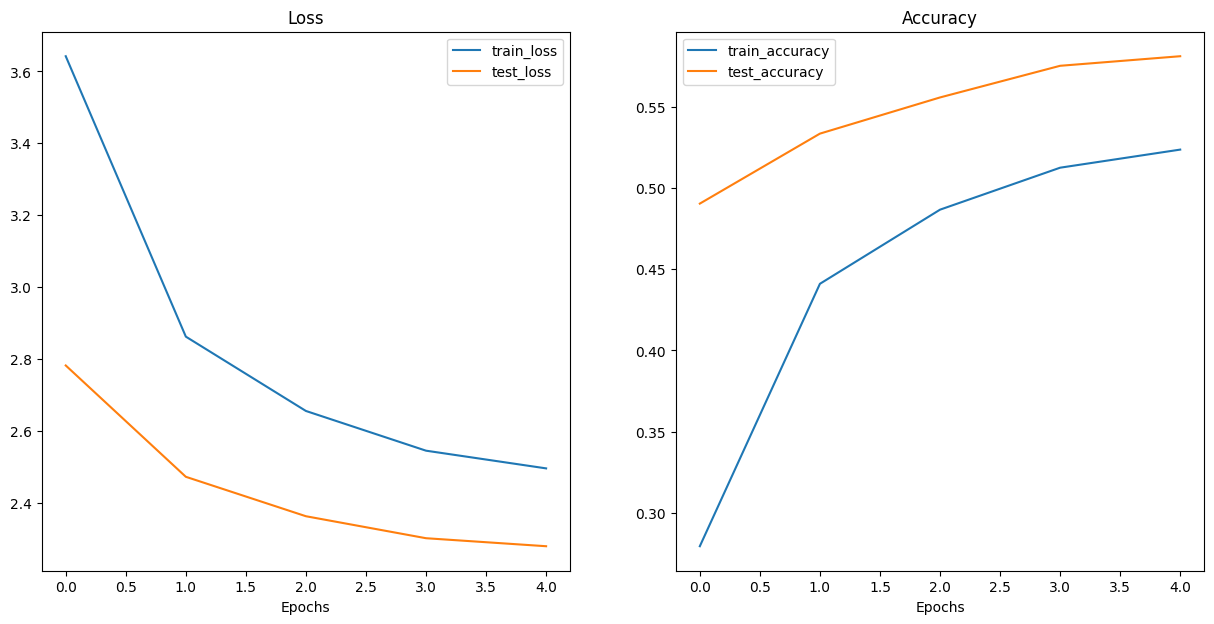

In [81]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big


In [82]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [83]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size


In [84]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


| **Model** | **Output shape (num classes)** | **Trainable parameters** | **Total parameters** | **Model size (MB)** |
| ----- | ----- | ----- | ----- | ----- |
| FoodVision Mini (EffNetB2 feature extractor) | 3 | 4,227 | 7,705,221 |  29 |
| FoodVision Big (EffNetB2 feature extractor) | 101 | 142,309 | 7,843,303 | 30 |


## 11. Turning our FoodVision Big model into a deployable app



When we're finished we'll have the following file structure:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [85]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [86]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading an example image and moving it to the `example` directory

In [87]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2023-08-30 02:24:04--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.07s   

2023-08-30 02:24:04 (40.8 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)


In [88]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Ideally, we want our class names to be saved like:

```
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
...
```

In [89]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [90]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)


In [91]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)


The `app.py` file will have four major parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with a Python list.
2. Model and transforms preparation - we'll need to make sure our model is suitable for FoodVisionBig
3. Predict function (`predict()`) - This can stay the same as the original `predict()`
4. Gradio app- our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates.

In [92]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big (`requirements.txt`)


In [93]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files


In [94]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big app to HuggingFace Spaces

Let's bring FoodVision Big to life by deploying it to the world!

Steps:

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_big`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_big
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_big` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_big` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"`.
    * **Note:** If you get any errors uploading images, you may have to track them with `git lfs` too, for example `git lfs track "examples/04-pizza-dad.jpg"`
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Big Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_big/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_big` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

In [95]:
# IPython is a library to help work with Python iteractively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an iFrame
IFrame(src="https://hf.space/embed/Rubb/FoodVisionBig/+", width=900, height=750)